# Exercise 8:

Embedded Reber grammars were used by Hochreiter and
Schmidhuber in their paper about LSTMs. They are artificial
grammars that produce strings such as “BPBTSXXVPSEPE.”
Check out Jenny Orr’s [nice introduction](https://willamette.edu/~gorr/classes/cs449/reber.html) to this topic. Choose a
particular embedded Reber grammar (such as the one represented
on Jenny Orr’s page), then train an RNN to identify whether a
string respects that grammar or not. You will first need to write a
function capable of generating a training batch containing about
50% strings that respect the grammar, and 50% that don’t.

First we need to build a function that generates strings based on grammer. The grammer will be represented as list of possible transitions for each state. A transition specifies the string to output and the next state. 

**Reber Grammer:**

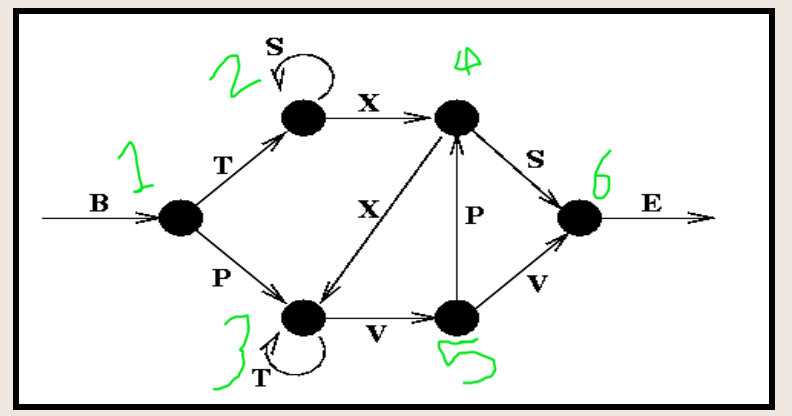

**Embedded Reber Grammer:**

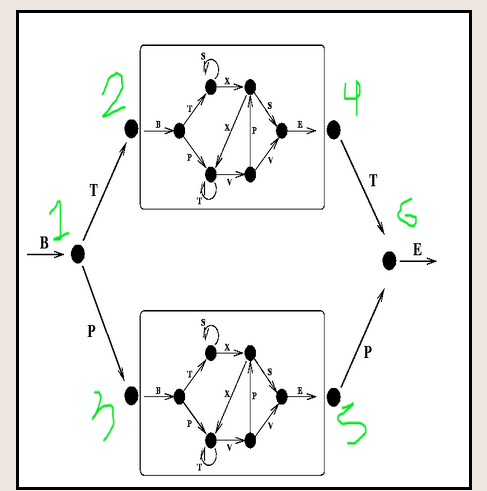

In [1]:
import numpy as np

In [4]:
default_reber_grammer = [
    [("B", 1)],             # (state 0) =B=> (state 1)
    [("T", 2), ("P", 3)],   # (state 1) =T=> (state 2) or =P=> (state 3)
    [("S", 2), ("X", 4)],   # (state 2) =S=> (state 2) or =X=> (state 4)
    [("T", 3), ("V", 5)],   # (state 3)
    [("X", 3), ("S", 6)],   # (state 4)
    [("P", 4), ("V", 6)],   # (state 5)
    [("E", None)]           # (state 6) =E=> (terminal state)
]

embedded_reber_grammer = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammer, 4)],
    [(default_reber_grammer, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]
]

def generate_string(grammer):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammer[state]))
        production, state = grammer[state][index]
        if isinstance(production, list):
            production = generate_string(grammer=production)
        output.append(production)
    return "".join(output)

Let's generate few strings based on default Reber Grammer.

In [5]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammer), end = " ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate few strings based on embedded reber grammer.

In [6]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammer), end = " ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [7]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammer, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammer)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index+1: ]

Let's look at few corrupted strings:

In [8]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammer), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

We cannot feed strings directly to an RNN, so we need to encode them somehow. One option would be to one-hot encode each character. Another option is to use embeddings. Let's go for second option (but since there are just handful of characters, one-hot encoding would be fine too). For embeddings to work, we need to convert each string into sequence of character IDs. Let's write a function for that, using each character's index in the string of possible characters "BEPSTVX":